In [1]:
from osgeo import gdal 
import xarray as xr 
import rioxarray as rio
import rasterio
import rasterio.plot
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

In [2]:
# ds = xr.open_dataset('sample/indonesia-20230901-20230907.nc')
ds = xr.open_dataset('http://182.16.248.173:8080/dods/INA-NWP/2023102800/2023102800-d01-asim')

c:\Users\falbas\miniconda3\Lib\site-packages\xarray\coding\times.py:167: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [35]:
t_tiff = 'temp.tiff'
rgb_tiff = "rgb.tiff"
# t = ds['t2m']
# _t = t[0].rio.set_spatial_dims(x_dim='longitude', y_dim='latitude')
t = ds['tc']
_t = t[0][0].rio.set_spatial_dims(x_dim='lon', y_dim='lat')
_t.rio.crs
_t.rio.write_crs("epsg:4326", inplace=True)
_t.rio.to_raster(t_tiff)

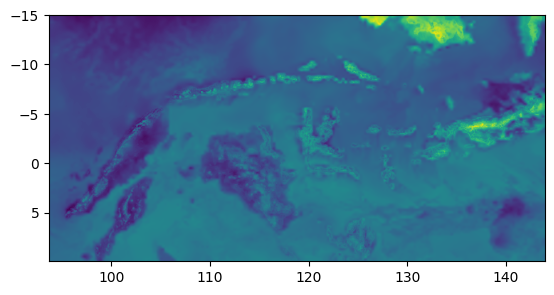

In [4]:
tiff = rasterio.open(t_tiff)
rasterio.plot.show(tiff)
tiff.close()

In [5]:
subprocess.run([r"gdaldem.exe", "color-relief", t_tiff, "tc_color.txt", rgb_tiff])

CompletedProcess(args=['gdaldem.exe', 'color-relief', 'temp.tiff', 'tc_color.txt', 'rgb.tiff'], returncode=0)

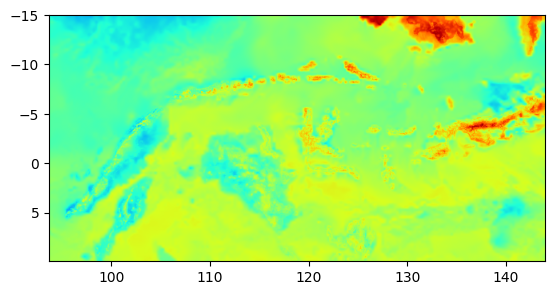

In [6]:
tiff = rasterio.open(rgb_tiff)
rasterio.plot.show(tiff)
tiff.close()

In [13]:
subprocess.run(["python", "C:/Users/falbas/miniconda3/Scripts/gdal2tiles.py", "--zoom=5-7", rgb_tiff, "tiles/baselayer1"])

CompletedProcess(args=['python', 'C:/Users/falbas/miniconda3/Scripts/gdal2tiles.py', '--zoom=5-7', 'rgb.tiff', 'tiles/baselayer1'], returncode=0)

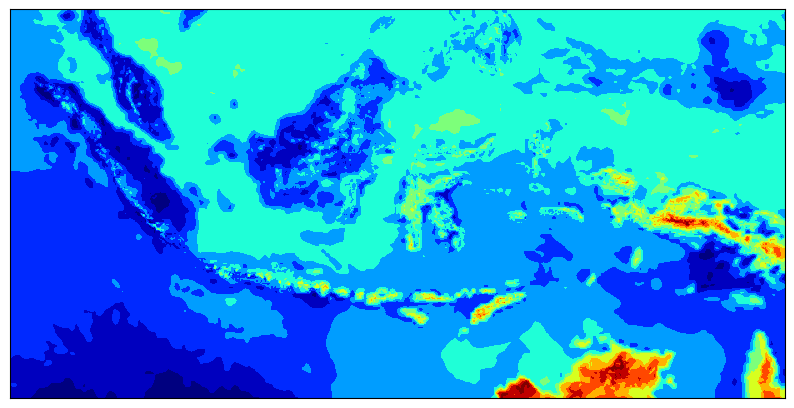

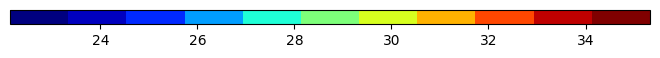

In [16]:
# Initialize the custom_colors list
custom_colors = []

with open("tc_color.txt", "r") as file:
    lines = file.readlines()
    # Process each line and convert the values
    for line in lines:
        values = line.split()
        if len(values) == 4:
            r, g, b = int(values[1]), int(values[2]), int(values[3])
            custom_colors.append((r, g, b))

# # Define your custom colormap as a list of colors
# custom_colors = [
#     (0, 0, 128),
#     (0, 0, 191),
#     (0, 41, 255),
#     (0, 157, 255),
#     (31, 255, 215),
#     (125, 255, 122),
#     (215, 255, 31),
#     (255, 178, 0),
#     (255, 71, 0),
#     (191, 0, 0),
#     (128, 0, 0)
# ]

custom_colors_normalized = [(r / 255, g / 255, b / 255) for r, g, b in custom_colors]

# Create the custom colormap
cmap = ListedColormap(custom_colors_normalized)

# Open the GeoTIFF file
src = rasterio.open(t_tiff)

# Read the image data and colormap
data = src.read(1)  # Change the band number as needed
# src.close()
data = np.flip(data, axis=0)
# cmap = plt.get_cmap("turbo")  # You can change the colormap as needed

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Display the GeoTIFF image
img = ax.imshow(data, cmap=cmap)

# Remove the x and y tick labels
ax.set_xticks([])
ax.set_yticks([])

fig.savefig("rgb.png", dpi=300, bbox_inches="tight", transparent=True, pad_inches=-0.1)

# Create a separate figure for the colorbar
colorbar_fig = plt.figure()
colorbar_ax = colorbar_fig.add_subplot([0, 0, 1, 0.03])

# Add the colorbar to the separate figure
colorbar = fig.colorbar(img, cax=colorbar_ax, orientation="horizontal")
# for ticklabel in colorbar.ax.get_xticklabels():
#     ticklabel.set_color("white")

# Save the colorbar as a PNG image
colorbar_fig.savefig("colorbar.png", dpi=300, bbox_inches="tight", transparent=True)

# Show the plot
plt.show()

In [41]:
src = rasterio.open(t_tiff)
bounds = src.bounds
src.close()
print(src.transform)

| 0.08, 0.00, 93.69|
| 0.00, 0.08,-15.04|
| 0.00, 0.00, 1.00|


In [57]:
dataset = rasterio.open("rgb.png", "r")
bands = [1, 2, 3]
data = dataset.read(bands)
transform = rasterio.transform.from_bounds(
    bounds.left, bounds.top, bounds.right, bounds.bottom, data.shape[1], data.shape[2]
)
# rasterio.plot.show(dataset)
# crs = {"init": "epsg:4326"}

with rasterio.open(
    "rgb2.tiff",
    "w",
    driver="GTiff",
    width=data.shape[1],
    height=data.shape[2],
    count=3,
    dtype=data.dtype,
    nodata=0,
    transform=transform,
    crs=src.crs,
) as dst:
    dst.write(data, indexes=bands)

dataset.close()

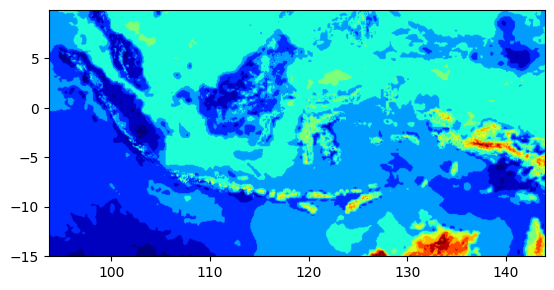

In [54]:
rgb = rasterio.open('rgb2.tiff')
rasterio.plot.show(rgb)
rgb.close()

In [52]:
subprocess.run(["python", "C:/Users/falbas/miniconda3/Scripts/gdal2tiles.py", "--zoom=5-7", "rgb2.tiff", "tiles/baselayer1"])

CompletedProcess(args=['python', 'C:/Users/falbas/miniconda3/Scripts/gdal2tiles.py', '--zoom=5-7', 'rgb2.tiff', 'tiles/baselayer1'], returncode=0)